In [4]:
!pip install numpy pandas matplotlib seaborn wordcloud emoji

In [5]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import emoji
# import itertools
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [6]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr': '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr': '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom': ''
    }
    datetime_formats = {
        '12hr': '%d/%m/%Y, %I:%M %p - ',
        '24hr': '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split(
            '\n'))  # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string)[
                   1:]  # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string)  # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})  # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s',
                     i)  # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if (a[1:]):  # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else:  # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    return df

In [7]:
df = rawToDf('whatsapp.txt', '12hr')

df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

           date  message_count
0    2019-08-12             19
1    2019-08-13              3
2    2019-08-14             19
3    2019-08-15              3
4    2019-08-18             19
..          ...            ...
534  2021-05-22              5
535  2021-05-23              6
536  2021-05-24             29
537  2021-05-25             15
538  2021-05-26              2

[539 rows x 2 columns]


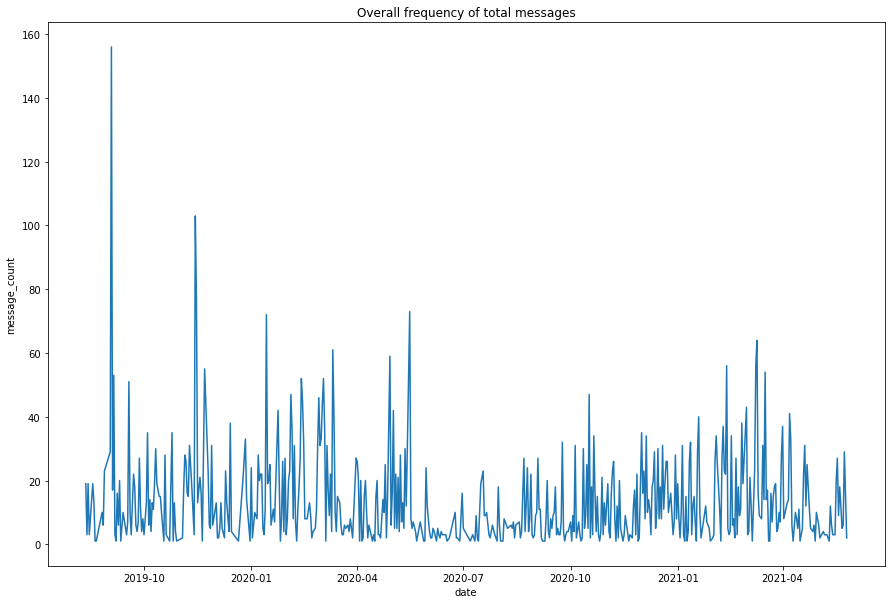

In [8]:
new_df = df.copy()

new_df['message_count'] = new_df.shape[0]*[1]
new_df = new_df.groupby('date').sum().reset_index()
new_df.drop(columns = 'year', inplace = True)
print(new_df)

plt.figure(figsize = (15, 10))
plt.title('Overall frequency of total messages')
sns.lineplot(new_df.date, new_df.message_count)


In [9]:
top10days = new_df.sort_values(by='message_count', ascending=False).head(10)
top10days.reset_index(inplace=True)
top10days.drop(columns='index', inplace=True)
top10days

,date,message_count
0,2019-09-03,156
1,2019-11-14,103
2,2019-11-15,76
3,2020-05-16,73
4,2020-01-14,72
5,2021-03-10,64
6,2020-03-11,61
7,2020-04-29,59
8,2021-02-12,56
9,2021-03-09,56


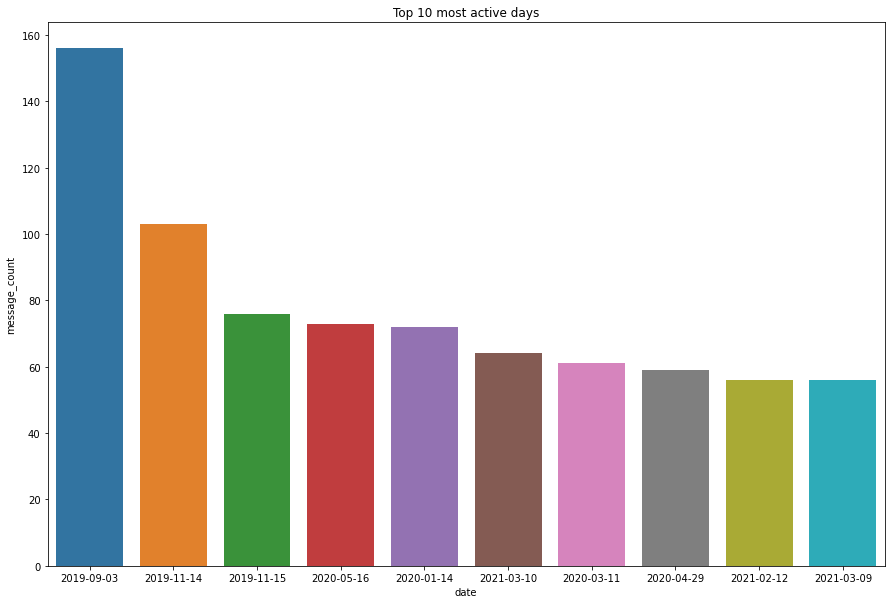

In [10]:
plt.figure(figsize = (15, 10))
plt.title('Top 10 most active days')
sns.barplot(top10days.date, top10days.message_count)

# Top 10 active users

In [11]:
df2 = df.copy()
df2 = df2[df2.user != 'group_notification']
top10users = df2.groupby('user')['message'].count().sort_values(ascending=False)
top10users = top10users.head(10).reset_index()
top10users

,user,message
0,IPL Sai Sunder,1084
1,Guru,903
2,Koustav,380
3,Juhi,307
4,Meera,223
5,Pallavi,222
6,IPL2,220
7,Dhanashree,215
8,+91 88844 46840,190
9,Ipsita,184


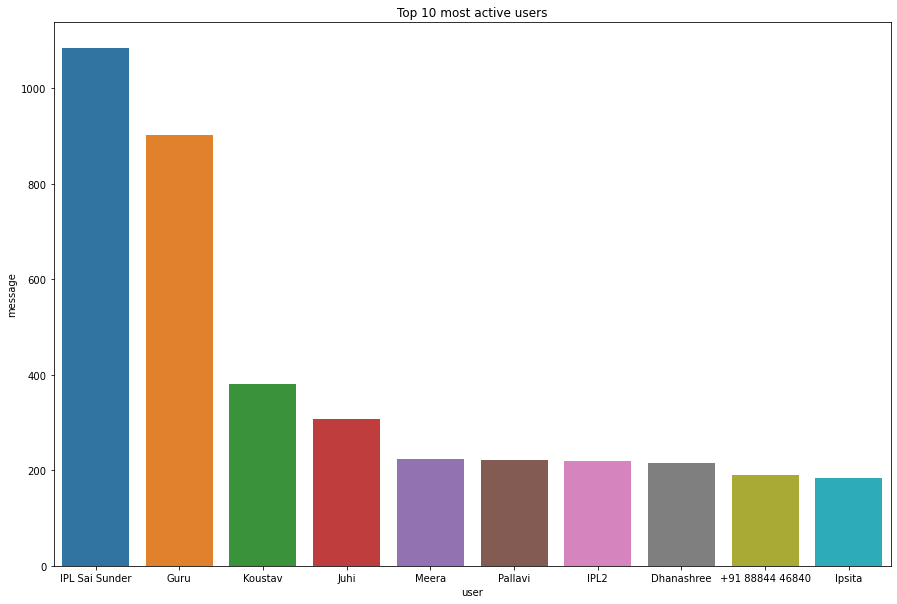

In [12]:
plt.figure(figsize = (15, 10))
plt.title('Top 10 most active users')
sns.barplot(top10users.user, top10users.message)

# Top most used words

In [17]:
df3 = df.copy()

common_words = ''

for val in df3.message.values:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for word in tokens:
        common_words = common_words + str(word) + ''
        
wordcloud = WordCloud(width=1000, height=800, 
                      background_color = 'white',
                     min_font_size=8).generate(common_words)

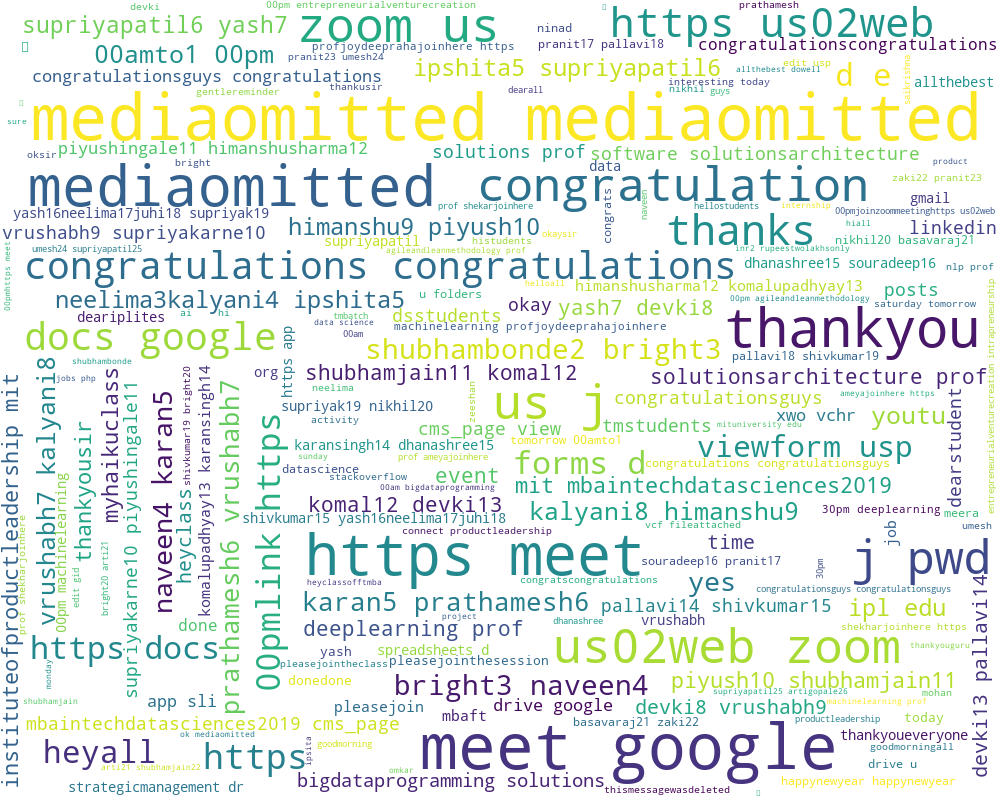

In [18]:
wordcloud.to_image()

In [21]:
wordcloud.to_file("first_review.png")